#### pre-processing

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os
# !pip install wget
# import wget
# !pip install requests gdown
# import gdown

In [2]:
# Hyper-parameter and setting
image_size = 28
batch_size = 2048
channel_size = 3
lr = 1e-3
num_epochs_teacher = 10
num_epochs_student = 10
num_classes = 10

In [3]:
# var init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data pre-processing of source and target domain
tf_source = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.1307,],  # Normalization as MNIST setting
                        std=[0.30,],
                        )
])

tf_target = transform.Compose([
    transform.Resize(image_size),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],  # Normalization as default setting
                        std=[0.5, 0.5, 0.5],
                        )
])

########################################################################################
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Dataset and dataloader source & target domain (train_set)
# Ds_source = datasets.MNIST(root='Dataset/mnist_dataset/', download=True, train=True, transform=tf_source)
# Dl_source = DataLoader(Ds_source, batch_size, shuffle=True, num_workers=2)

# Download here: https://drive.google.com/drive/folders/14IgFgyHyJ3I8-VPzzA33sBF1w2E1mVVt?usp=sharing
# Mount and unzip from directory
from google.colab import drive
drive.mount('./drive/')
!unzip './drive/MyDrive/99H_datasets/MNIST_M.zip'
# Upload directly
# !unzip './MNIST_M.zip

# Ds_target = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
# Dl_target = DataLoader(Ds_target, batch_size, shuffle=True, num_workers=2)
# train_split = 0.8
# train_size = int(train_split * len(Dl_target))
# test_size = len(Dl_target) - train_size
# Dl_tar_training_set, Dl_tar_testing_set = torch.utils.data.random_split(Dl_target, [train_size, test_size])
Ds_target_train = datasets.ImageFolder(root='./MNIST_M/train', transform=tf_target)
Dl_tar_training_set = DataLoader(Ds_target_train, batch_size, shuffle=True, num_workers=2)
Ds_target_test = datasets.ImageFolder(root='./MNIST_M/test', transform=tf_target)
Dl_tar_testing_set = DataLoader(Ds_target_test, batch_size, shuffle=True, num_workers=2)

Streaming output truncated to the last 5000 lines.
 extracting: MNIST_M/train/9/00008555.png  
 extracting: MNIST_M/train/9/00008558.png  
 extracting: MNIST_M/train/9/00008563.png  
 extracting: MNIST_M/train/9/00008581.png  
 extracting: MNIST_M/train/9/00008585.png  
 extracting: MNIST_M/train/9/00008586.png  
 extracting: MNIST_M/train/9/00008592.png  
 extracting: MNIST_M/train/9/00008601.png  
 extracting: MNIST_M/train/9/00008608.png  
 extracting: MNIST_M/train/9/00008620.png  
 extracting: MNIST_M/train/9/00008626.png  
 extracting: MNIST_M/train/9/00008630.png  
 extracting: MNIST_M/train/9/00008641.png  
 extracting: MNIST_M/train/9/00008654.png  
 extracting: MNIST_M/train/9/00008669.png  
 extracting: MNIST_M/train/9/00008671.png  
 extracting: MNIST_M/train/9/00008674.png  
 extracting: MNIST_M/train/9/00008702.png  
 extracting: MNIST_M/train/9/00008714.png  
 extracting: MNIST_M/train/9/00008721.png  
 extracting: MNIST_M/train/9/00008736.png  
 extracting: MNIST_M/trai

In [28]:
#---Regularization term configs---
kd_compress = True  # KD compression in use?
kd_weight = 0.3  # KD weight to control capability of transferring knowledge
kd_temp = 2.0    # KD temperature
#---------------------------------

In [29]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

--------------
#### Simple Knowledge Distillation (KD)
Hinton, Geoffrey, Oriol Vinyals, and Jeff Dean. "Distilling the knowledge in a neural network." arXiv preprint arXiv:1503.02531 (2015).\
Referred doc: https://arxiv.org/abs/1503.02531


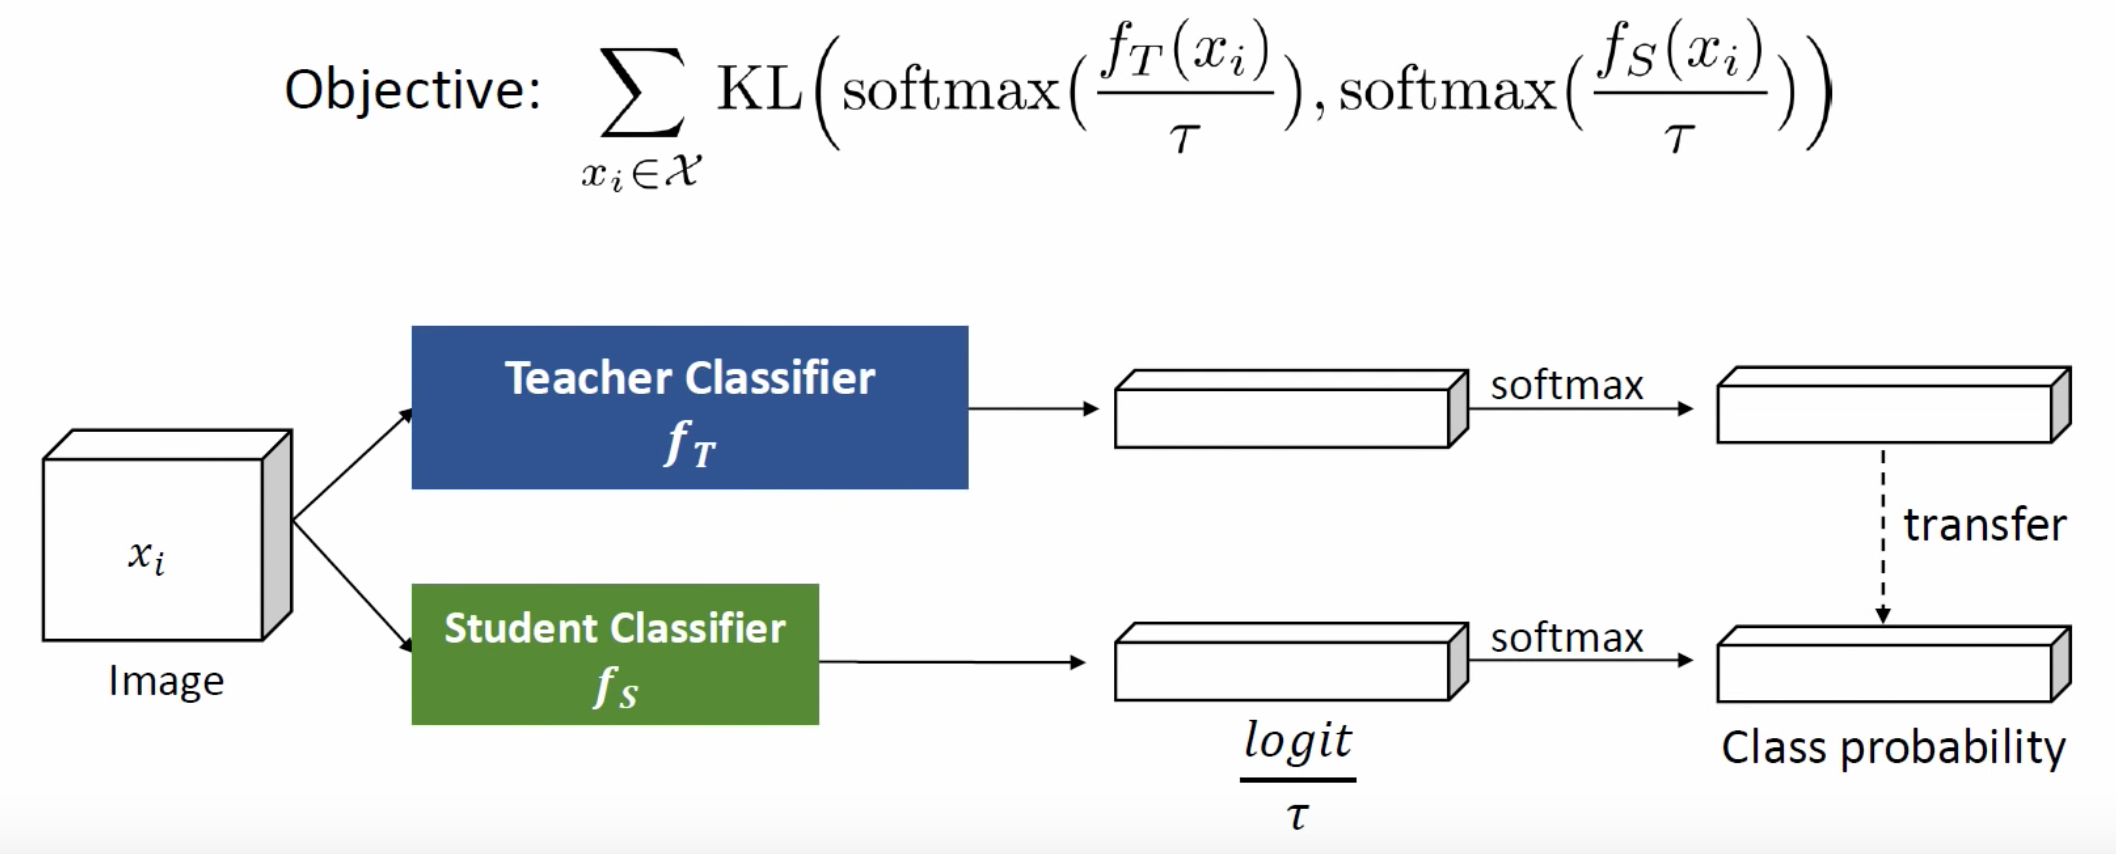

In [30]:
########################################################################################
class DistillKL(nn.Module):
    """
      Arg:
      Distilling the Knowledge in a Neural Network
    """
    def __init__(self, Temperature):
        super(DistillKL, self).__init__()
        self.Temperature = Temperature

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.Temperature, dim=1)
        #p_s = F.softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.Temperature, dim=1)
        loss = F.kl_div(p_s, p_t, reduction='sum') * (self.Temperature**2) / y_s.shape[0]
        return loss

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class teacher_model(nn.Module):
    def __init__(self, n_C=10):
        super(teacher_model, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, n_C)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

# model = teacher_model(num_classes=10)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class student_model(nn.Module):
    def __init__(self, n_C=10):
        super(student_model, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, n_C)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

# model = student_model(num_classes=10)




```
# This is formatted as code
```

#### Teacher batch running

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

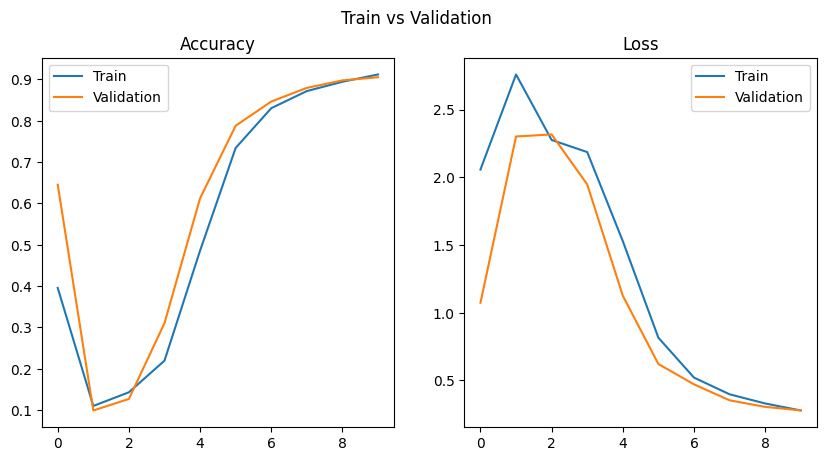

In [31]:
# Computational graph
# import torchviz
# from torchviz import make_dot
#
# reverse_out = make_dot(loss, params=dict(w=w))
# reverse_out.view()

# network
teacher_fn = teacher_model(n_C=num_classes).to(device)
summary(teacher_fn, input_size=(channel_size, image_size, image_size))

# Optimizer and cost function
optimizer = optim.Adam(teacher_fn.parameters(), lr)
loss_fn = torch.nn.CrossEntropyLoss()
# Training the same number of batches from both datasets
# max_batches = min(len(Dl_source), len(Dl_target))

###########################################################################
# 1st step: Training teacher net
t_0 = time.time()
iter_teacher = 0
best_vloss = 1_000_000.
training_logs_teacher = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
for epoch_T in range(num_epochs_teacher):
    train_loss, train_correct = 0, 0
    # print(f'epochs {epoch_T+1:04d} / {num_epochs_teacher:04d}', end='\n============\n')

    for i_T, data_T in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X_T, y_T = data_T[0].to(device), data_T[1].to(device)

        yhat_T = teacher_fn(X_T)
        loss = loss_fn(yhat_T, y_T)                 # source classification loss

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        with torch.no_grad():
          class_prediction_T = teacher_fn(X_T)

        # print(f'[{i_T+1}/{len(Dl_tar_training_set)}] '
        #       f'teacher class loss: {loss.item():.4f} '
        #       )
        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction_T.argmax(1) == y_T).float().sum().item()

    training_logs_teacher["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_teacher["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    teacher_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = teacher_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_teacher["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_teacher["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch_T % 1 == 0:
        print(f"Epochs {epoch_T+1}".ljust(10),
            f"train loss {training_logs_teacher['train_loss'][-1]:.5f}",
            f"train acc {training_logs_teacher['train_acc'][-1]:.5f}",

            f"validate loss {training_logs_teacher['val_loss'][-1]:.5f}",
            f"validate acc {training_logs_teacher['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(teacher_fn.state_dict(), path_save_cp+'best_teacher_model.pth')

    iter_teacher += 1

t_end = time.time()-t_0
print(f"Time consumption for teacher net (device:{device}): {t_end} sec")

plot_graph(training_logs_teacher)

#### Teacher to student distillation

<ipython-input-32-2bc8b53e1a85>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(path)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

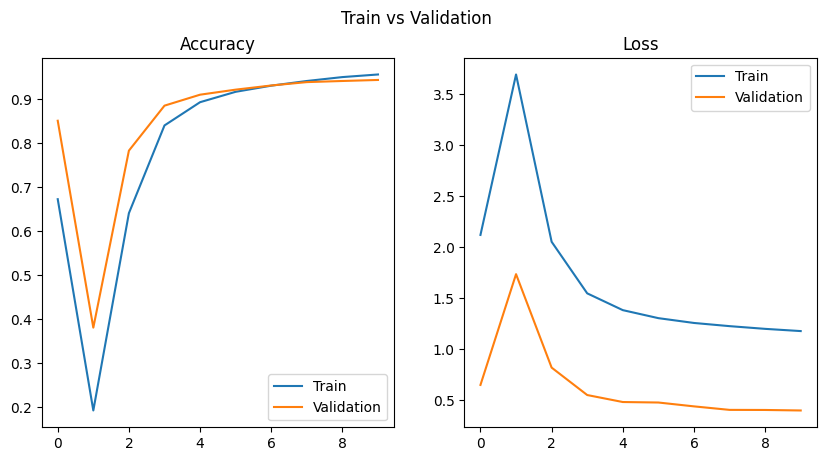

In [32]:
# Computational graph
# import torchviz
# from torchviz import make_dot
#
# reverse_out = make_dot(loss, params=dict(w=w))
# reverse_out.view()

# network
teacher_fn = teacher_model(n_C=num_classes).to(device)
teacher_model_dict=teacher_fn.state_dict()
path = path_save_cp+'/best_teacher_model.pth'
pretrained_dict = torch.load(path)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in teacher_model_dict) and (teacher_model_dict[k].shape == pretrained_dict[k].shape)}
teacher_model_dict.update(pretrained_dict)
teacher_fn.load_state_dict(teacher_model_dict)

student_fn = student_model(n_C=num_classes).to(device)
summary(student_fn, input_size=(channel_size, image_size, image_size))

# Optimizer and cost function
optimizer = optim.Adam(student_fn.parameters(), lr)
# optimizer = optim.SGD(student_fn.parameters(), lr, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
# Training the same number of batches from both datasets
# max_batches = min(len(Dl_source), len(Dl_target))

###########################################################################
# 2nd step: Training student net
t_0 = time.time()
iter_student = 0
best_vloss = 1_000_000.
training_logs_student = {"train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}
for epoch_S in range(num_epochs_student):
    train_loss, train_correct = 0, 0
    # print(f'epochs {epoch_S+1:04d} / {num_epochs_student:04d}', end='\n============\n')

    for i_S, data_S in enumerate(Dl_tar_training_set):
    # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):

        # zero parameters gradient to Net and optimizer
        # model.zero_grad()
        optimizer.zero_grad()

        # GPU processing source and target data
        X_S, y_S = data_S[0].to(device), data_S[1].to(device)

        yhat_S = student_fn(X_S)
        loss = loss_fn(yhat_S, y_S)                 # source classification loss

        #Distilling
        if kd_compress:
          # No need to update teacher net (freeze teacher weights)
          with torch.no_grad():
              yhat_T = teacher_fn(X_S)
          loss_kd = DistillKL(Temperature=kd_temp)(yhat_S, yhat_T)
          loss += kd_weight * loss_kd

        # back-propagation (reversed grad to maximize domain loss)
        loss.backward()
        # optimization tuning
        optimizer.step()

        # #output predict from net
        with torch.no_grad():
          class_prediction_S = student_fn(X_S)

        # base_message = (f'[{i_S+1}/{len(Dl_tar_training_set)}] '
        #                 f'student class loss: {loss.item():.4f} ')
        # if kd_compress:
        #   base_message += f'Knowledge distillation loss: {loss_kd.item():.4f} '
        # print(base_message)

        # if batch_idx == 50:
        #     print('This is just a demo, stopping...')
        #     break

        train_loss += loss.item()
        train_correct += (class_prediction_S.argmax(1) == y_S).float().sum().item()

    training_logs_student["train_loss"].append(train_loss / len(Dl_tar_training_set))
    training_logs_student["train_acc"].append(train_correct / len(Dl_tar_training_set.dataset))#.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    student_fn.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(Dl_tar_testing_set):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = student_fn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save testing logs
        training_logs_student["val_loss"].append(valid_loss / len(Dl_tar_testing_set))
        training_logs_student["val_acc"].append(valid_correct / len(Dl_tar_testing_set.dataset))

    if epoch_S % 1 == 0:
        print(f"Epochs {epoch_S+1}".ljust(10),
            f"train loss {training_logs_student['train_loss'][-1]:.5f}",
            f"train acc {training_logs_student['train_acc'][-1]:.5f}",

            f"validate loss {training_logs_student['val_loss'][-1]:.5f}",
            f"validate acc {training_logs_student['val_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        path_save_cp = './cp/'
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(student_fn.state_dict(), path_save_cp+'best_student_model.pth')

    iter_student += 1

t_end = time.time()-t_0
print(f"Time consumption for student net (device:{device}): {t_end} sec")

plot_graph(training_logs_student)

# Summarize
Knowledge distillation is a machine learning technique where a smaller, simpler model (the "student") is trained to replicate the behavior of a larger, more complex model (the "teacher"). The process involves using the teacher model to generate soft predictions or probability distributions for a dataset, which are then used to train the student model. This approach leverages the teacher's more nuanced understanding of the data to guide the student, enabling the smaller model to achieve comparable performance while being more efficient in terms of computation and memory. Knowledge distillation is particularly useful for deploying models in resource-constrained environments.

# In-class exercises

จงกลั่นความรู้จากตัวอย่างโมเดลครูและโมเดลนักเรียนในตัวอย่าง โดยการปรับน้ำหนักควบคุมและอุณหภูมิ

```
kd_weight = [0.6, 0.8, 1.0]
kd_temp = [1.5, 1.75, 2.0]
```

จงเลือกค่าจากคู่ [kd_weight, kd_temp] ที่ดีที่สุดสำหรับการกลั่นความรู้ เปรียบเทียบและอธิบายผลที่จำนวนรอบการเรียนรู้วนซ้ำที่ 5 รอบเท่ากัน เมื่อเทียบกับกรณีไม่มีกลั่นความรู้

```
kd_weight, kd_temp = 0.0, 1.0
```

จัดทำเป็น PDF ส่ง

# Homework
จงบีบอัดและกลั่นความรู้จาก Pretrained ResNet-50 ไปยัง ResNet-18 (Referred model in W4-2) โดยให้ตั้งค่า hyper-parameter ทั้งแบบไม่กลั่นความรู้และบีบอัดกลั่นความรู้ ที่ setting เดียวกันและ 10 รอบการวนซ้ำเท่ากัน โดยปรับในส่วนของ

กรณีไม่กลั่นความรู้
*   Train ResNet18 only

กรณีกลั่นความรู้
*   Pretrained ResNet50 (freezed weight: ImageNet-1K) --> ResNet18
*   น้ำหนักอุณหภูมิ (Temperature) ในการ softening outputs
```
kd_temp = [1.0, 1.5, 2.0]
```
*   น้ำหนักควบคุม (kd_weight) ความสามารถส่งผ่านของ knowledge distillation
```
kd_weight = [0.0, 0.3, 0.5, 0.8, 1.0]
```




\
>เปรียบเทียบและอภิปรายผล Quantitative and visualization results (acc., loss, precision, recall, F1, confusion matrix, etc.) จัดส่งเป็น PDF ระหว่าง non-distilled student
```
kd_weight, kd_temp = 0.0, 1.0
```
กับ distilled student (จากการปรับ temp และ kd_weight ในหลาย ๆ ค่าและเลือกค่าจากคู่ที่ดีที่สุดจากการฝึกฝนการกลั่นความรู้)
```
kd_weight, kd_temp = best, best
```



